# Preface

In this notebook, we visualize the K-means algorithm and also demonstrate some useful applications, including image compression and segmentation. We also introduce anomaly detection using the Gaussian mixture models, which can be seen as an extension of the K-means algorithm.

In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('notebook', font_scale=1.25, rc={"lines.linewidth": 2.5})
sns.set_style("darkgrid")
np.random.seed(123)  # For reproducibility

# Visualizing The K-means Algorithm

We first visualize how the K-means algorithm works on a toy dataset.

## Generate Data

Let us use `sklearn.datasets.make_blobs` to make a simple toy dataset for clustering.

In [4]:
from sklearn.datasets import make_blobs

In [40]:
x, y = make_blobs(
    n_samples=100,
    n_features=2,
    cluster_std=1.0,
    random_state=13,
)

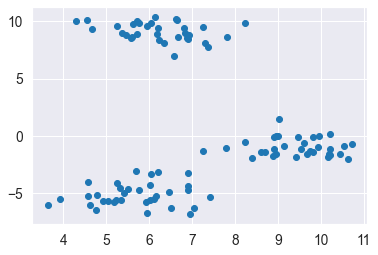

In [41]:
plt.scatter(x[:,0], x[:,1])

## K-means Algorithm

We will write a simple class to carry out K-means steps and plot graphs to visualize what is happening. Of course, in practice we will use canned functions from `sklearn.cluster` module. Nevertheless, it doesn't hurt to code this up at least once to understand what is going on!

In [42]:
class KMeansClustering(object):
    """
    A crude K-means algorithm implementation
    with visualizations
    """
    
    def __init__(self, X, K):
        self.X = X
        self.K = K
        self.N = X.shape[0]
        self.d = X.shape[1]
        self.iter_count = 0
        
        # Initializations
        self.reset()
        
        # Colors
        self.c = sns.color_palette()
        
    def reset(self):
        """
        reset Z and R estimations
        """
        self.Z = self.init_Z()
        self.update_R()
        self.status = 'Initialized'
        self.losses = []
        self.update_loss()
    
    def init_R(self):
        """
        Initialize assignment matrix R
        """
        assignment = np.random.choice(range(self.K), size=(self.N))
        R = np.zeros(shape=(self.N, self.K))
        R[np.arange(self.N), assignment] = 1
        return R
        
    def init_Z(self):
        """
        Initialize cluster means Z
        """
        chosen_idx = np.random.choice(range(self.N), size=(self.K))
        return self.X[chosen_idx]
    
    def update_R(self):
        """
        Update assignment matrix R
        """
        diff = self.X.reshape(self.N, 1, self.d) - self.Z.reshape(1, self.K, self.d)
        diff_norm = np.linalg.norm(diff, axis=-1)
        assignment = diff_norm.argmin(axis=-1)
        R = np.zeros(shape=(self.N, self.K))
        R[np.arange(self.N), assignment] = 1
        self.R = R
        self.status = 'Updated R'

    def update_Z(self):
        """
        Compute cluster means Z
        """
        Z = []
        for r in self.R.T:
            Z.append(np.mean(self.X[r.astype(np.bool)], axis=0))
        self.Z = np.asarray(Z)
        self.status = 'Updated Z'
        
    def plot(self, ax):
        """
        Visualize the centers and assignments
        """
        X_colors = [self.c[i] for i in self.R.argmax(1)]
        ax.scatter(self.X[:, 0], self.X[:, 1], edgecolors='w', c=X_colors, alpha=0.5)
        
        Z_colors = [self.c[i] for i in range(self.K)]
        ax.scatter(self.Z[:, 0], self.Z[:, 1], marker='*', s=500, c=Z_colors)
        ax.set_xlabel(r'$x_1$')
        ax.set_ylabel(r'$x_2$')
        ax.set_title(f'Iter: {self.iter_count} | {self.status}')
        
    def step(self):
        """
        Updated Z and R alternatively
        """
        if self.status == 'Updated Z':
            self.update_R()
        elif self.status == 'Updated R':
            self.update_Z()
        else:
            self.update_Z()
        self.iter_count += 1
        self.update_loss()

    def update_loss(self):
        """
        Update loss function:
        within cluster sum of squares
        """
        assignments = self.R.argmax(1)
        X_centers = self.Z[assignments]
        diff = self.X - X_centers
        diff_norm = np.linalg.norm(diff, axis=-1)**2
        self.losses.append(0.5 * np.mean(diff_norm))

## K-Means Fitting in Action

Let us now observe how the K-means algorithm fits a dataset

In [57]:
km = KMeansClustering(X=x, K=3)

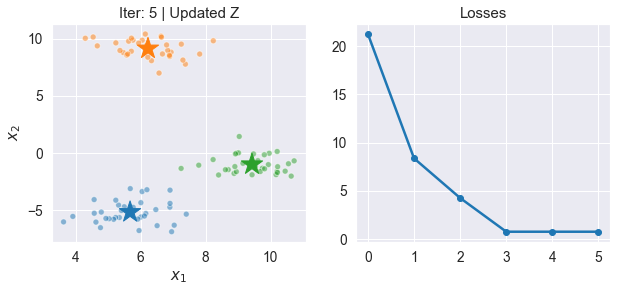

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
km.plot(ax[0])
ax[1].plot(km.losses, '-o')
ax[1].set_title('Losses')
km.step()

# K-means for Clustering Digits

Let us now apply the K-means algorithm to cluster some images of handwritten digits (Similar to MNIST, but lower resolution).

In [64]:
from sklearn.datasets import load_digits
digits = load_digits();

Instead of writing our own K-means solver, we will use the implementation in `sklearn`.

In [65]:
from sklearn.cluster import KMeans

In [67]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data / 255.0)

Let us visualize the centers

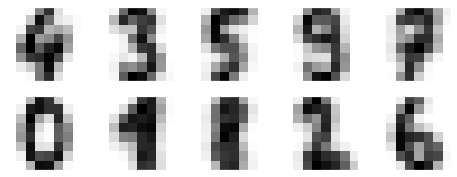

In [68]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(-1, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

## Selecting K

How do we select the number of clusters? 

We can try to use the "elbow" method: we observe how the loss decreases when we increase the number of clusters. We then choose $K$ to be the point where the loss starts to decrease less. 

Of course, this is not always reliable...

In [69]:
losses = []
for K in range(1, 30):
    kmeans = KMeans(n_clusters=K)
    kmeans.fit(digits.data / 255.0)
    losses.append(kmeans.inertia_)

Text(0, 0.5, 'Loss')

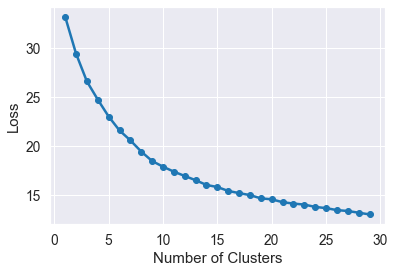

In [70]:
plt.plot(range(1,30), losses, '-o')
plt.xlabel('Number of Clusters')
plt.ylabel('Loss')

# K-means For Image Compression and Segmentation

Let us now see how we can use K-means to do some simple image processing.


We will use `opencv` to process images. Install it as follows:
```
$pip install opencv-python
```

In [71]:
import cv2

In [72]:
img = cv2.imread('data/nus_science.jpg')
img = img / 255.0
img = cv2.resize(img, (0,0), fx=0.25, fy=0.25) 

In [79]:
img.shape, 216*325*3

((216, 325, 3), 210600)

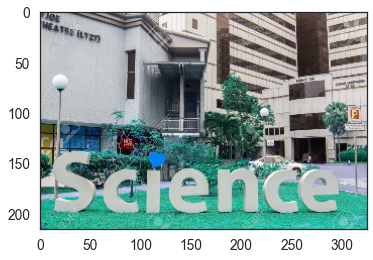

In [74]:
with sns.axes_style("white"):
    plt.imshow(img)

Let us now use K-means to cluster the pixel values (each is a 3D vector, representing hte R, G and B values respectively)

In [75]:
kmeans = KMeans(n_clusters=10, random_state=0)
kmeans.fit(img.reshape(-1, 3))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

Let us now transform the image, by replacing each pixel's RBG value to the closest cluster center

In [76]:
img_transformed = kmeans.cluster_centers_[kmeans.labels_]
img_transformed = img_transformed.reshape(img.shape)

Let us see how we have done.

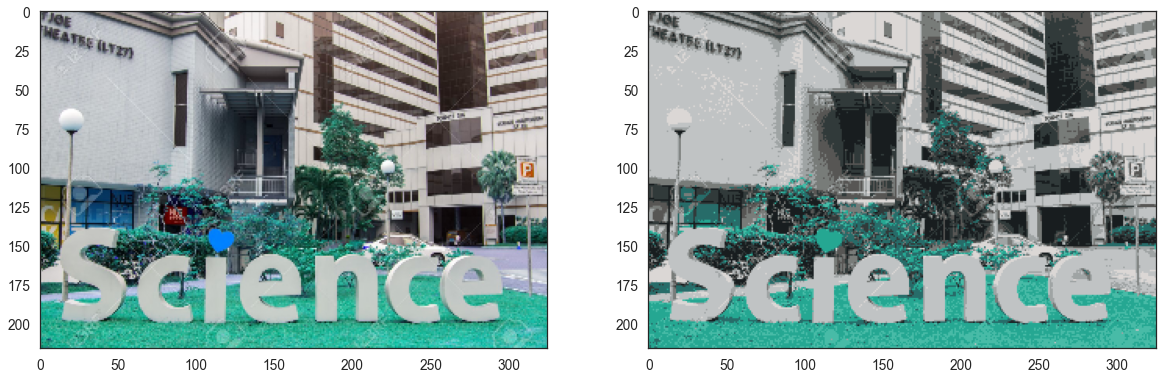

In [77]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(20, 8))
    ax[0].imshow(img)
    ax[1].imshow(img_transformed)

Observe that surprisingly little is lost by just having a few possible values for each pixel!

## Image Compression

The first application directly follows the reconstruction result: we have compressed the image in terms of the pixel values.

In [113]:
np.product(kmeans.labels_.shape)

70200

In [78]:
num_floats_original = np.product(img.shape)
num_floats_compressed = np.product(kmeans.cluster_centers_.shape) + np.product(kmeans.labels_.shape)

print(f'Number of floats in original image: {num_floats_original}')
print(f'Number of floats in K-means representation: {num_floats_compressed}')
print(f'Compression rate: {num_floats_compressed / num_floats_original}')

Number of floats in original image: 210600
Number of floats in K-means representation: 70230
Compression rate: 0.3334757834757835


## Image Segmentation

Another application is *image segmentation*. Here, we simply "classify" the pixels by their cluster-center assignments. This allows us to group patches of pixels together.

In [80]:
segmented_img = kmeans.labels_.reshape(img.shape[0], img.shape[1])

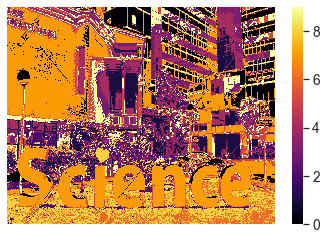

In [83]:
with sns.axes_style("white"):
    ax = sns.heatmap(segmented_img, cmap='inferno')
    ax.set_xticks([])
    ax.set_yticks([])

# Gaussian Mixture Model For Fraud Detection

Let us illustrate the usage of GMM for fraud detection. 
The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

The detailed description of the dataset is found [here](https://www.kaggle.com/mlg-ulb/creditcardfraud)

In [84]:
import kaggle
kaggle.api.authenticate()

kaggle.api.dataset_download_files(
    'isaikumar/creditcardfraud',
    path='./data',
    quiet=False,
    unzip=True
)

  3%|▎         | 2.00M/65.9M [00:00<00:05, 11.8MB/s]

100%|██████████| 65.9M/65.9M [00:06<00:00, 11.4MB/s]


In [85]:
data = pd.read_csv('./data/creditcard.csv')

**Brief Description of Features**

  * Time: seconds elapsed from first transaction
  * V1-V28: PCA transforms of raw features (raw features hidden for privacy)
  * Amount: total amount spent on the transaction
  * Class: 1 = Fraud, 0 = Normal

In [86]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


We have an extremely imbalanced dataset! Direct supervised learning requires careful data-balancing. 

We will proceed is another way using unsupervised density estimation with Gaussian mixtures.

In [87]:
print(f'Normal Transactions: {np.sum(data.Class == 0)}')
print(f'Fraudulent Transactions: {np.sum(data.Class == 1)}')

Normal Transactions: 284315
Fraudulent Transactions: 492


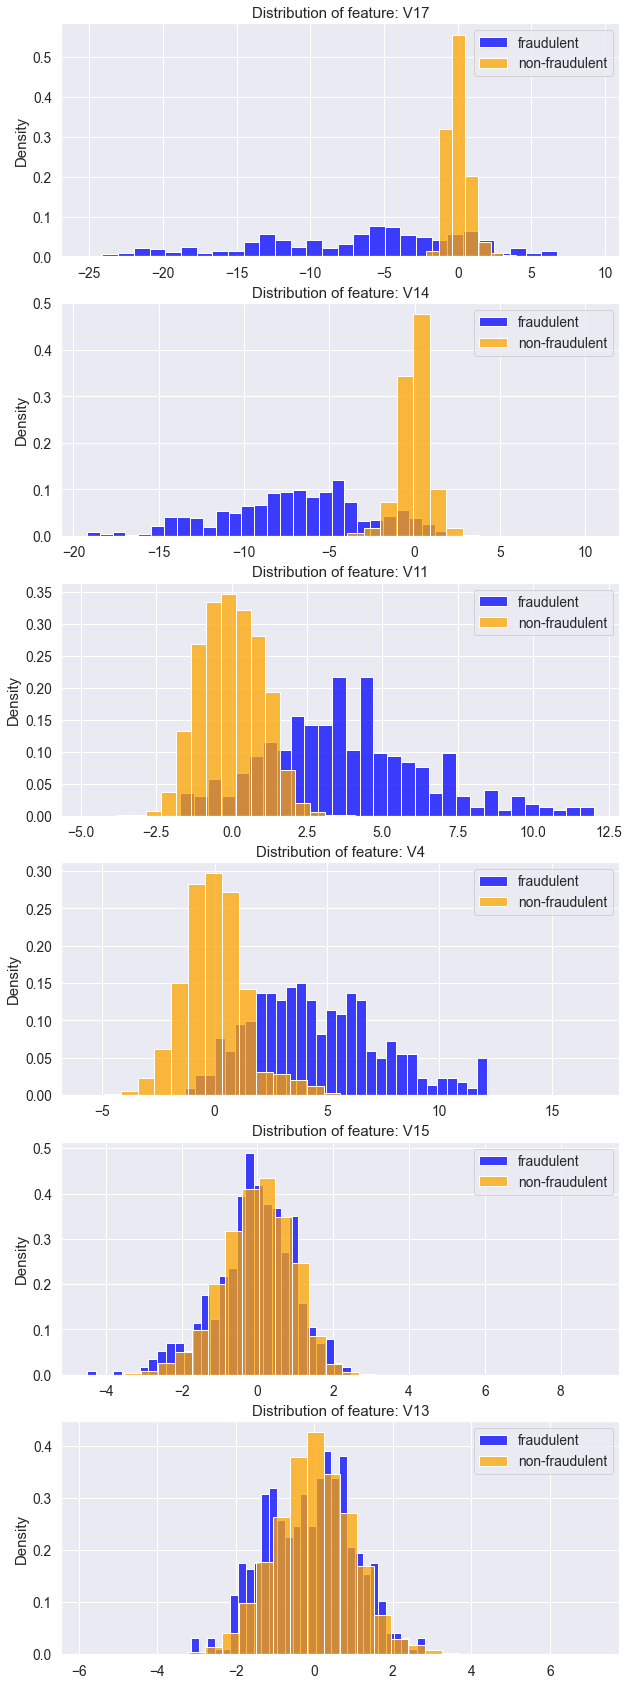

In [88]:
import matplotlib.gridspec as gridspec
features=['V17','V14', 'V11', 'V4', 'V15', 'V13']

fig, ax = plt.subplots(len(features), 1, figsize=(10, 5*len(features)))

for (f, a) in zip(features, ax):
    sns.histplot(data[f][data.Class==1], bins=30, ax=a, color='blue', stat='density')
    sns.histplot(data[f][data.Class==0], bins=30, ax=a, color='orange', stat='density')
    a.legend(['fraudulent', 'non-fraudulent'])
    a.set_xlabel('')
    a.set_title('Distribution of feature: ' + f)

## Training GMM on normal data

In [89]:
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture

We split the dataset to non-fraudulent and fraudulent portions

In [90]:
data_0=data[data.Class==0]
data_1=data[data.Class==1]

We shall only use two of the most correlated features, *V14* and *V17*

In [91]:
data_0=data_0[['V14', 'V17','Class']]    
data_1=data_1[['V14', 'V17', 'Class']]

Next, we do some data splitting.

We split 
  * the non-fraudulent data 90%-10% for training the GMM and testing
  * the fraudulent data 50%-50% for cross validation and testing

In [92]:
x_train, x_test, y_train, y_test = train_test_split(
    data_0.drop(['Class'], axis=1),
    data_0['Class'],
    test_size=0.1,
)
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(
    data_1.drop(['Class'], axis=1),
    data_1['Class'],
    test_size=0.5,
)

In [94]:
gmm = GaussianMixture(n_components=5)  # How do we choose n_components?

In [95]:
gmm.fit(x_train)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=5, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

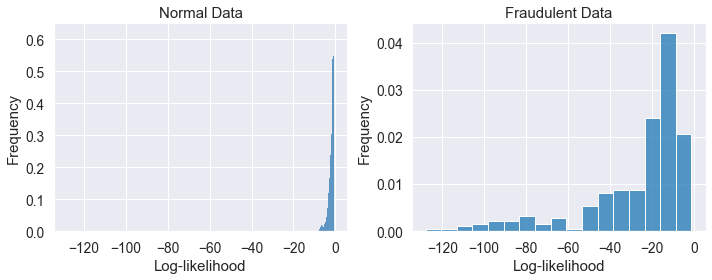

In [96]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
sns.histplot(gmm.score_samples(x_train), stat='density', ax=ax[0])
sns.histplot(gmm.score_samples(x_train_1), stat='density', ax=ax[1])

ax[0].set_title('Normal Data')
ax[1].set_title('Fraudulent Data')

for a in ax:
    a.set_xlabel('Log-likelihood')
    a.set_ylabel('Frequency')
    
fig.tight_layout()

In [99]:
np.exp(-20)

2.061153622438558e-09

## Set a threshold for fraud detection

We evaluate the performance of our model using different thresholds using *precision* and *recall*.

![Image of Yaktocat](https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/350px-Precisionrecall.svg.png)

Ideally, we want to have both precision and recall to be high. A summary statistic is the F1-score, given by
$$
    \text{F1-score}
    =
    2 
    \times
    \frac
    {
        \text{precision} \times \text{recall}
    }
    {
        \text{precision} + \text{recall}
    }
$$

In [100]:
from sklearn.metrics import precision_recall_fscore_support
def evaluate_threshold(x, y, thresholds):
    log_likelihoods = gmm.score_samples(x)
    precisions = []
    recalls = []
    f1s = []
    for t in thresholds:
        y_pred = 1 * (log_likelihoods < t)
        p, r, f1, _ = precision_recall_fscore_support(y, y_pred, average='binary')
        precisions.append(p)
        recalls.append(r)
        f1s.append(f1)
    return precisions, recalls, f1s

In [101]:
x_train_combined = np.concatenate([x_train, x_train_1])
y_train_combined = np.concatenate([y_train, y_train_1])

In [102]:
thresholds = np.linspace(-100, -5, 10)

In [103]:
p_train, r_train, f1_train = evaluate_threshold(x_train_combined, y_train_combined, thresholds)

Text(0.5, 0, 'Thresholds for log-likelihood')

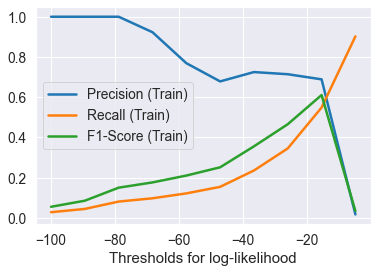

In [104]:
plt.plot(thresholds, p_train, label='Precision (Train)')
plt.plot(thresholds, r_train, label='Recall (Train)')
plt.plot(thresholds, f1_train, label='F1-Score (Train)')
plt.legend()
plt.xlabel('Thresholds for log-likelihood')

In [105]:
chosen_threshold = thresholds[np.argmax(f1_train)]

With the chosen threshold, let us use this to predict anomalies. Given a new test data point, we classify it as a Fraudulent transaction if its log-likelihood is smaller than the `chosen_threshold`.

In [106]:
from sklearn.metrics import classification_report

In [107]:
x_test_combined = np.concatenate([x_test, x_test_1])
y_test_combined = np.concatenate([y_test, y_test_1])

In [108]:
y_test_pred = gmm.score_samples(x_test_combined) < chosen_threshold

In [109]:
print(classification_report(y_test_combined, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.98      0.54      0.70       246

    accuracy                           1.00     28678
   macro avg       0.99      0.77      0.85     28678
weighted avg       1.00      1.00      1.00     28678

